# Deep Neural Network (DNN) retreival

---

## Imports

In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import seaborn as sns
from dask import delayed, compute
import itertools
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from dask.distributed import Client, LocalCluster
from sklearn.model_selection import train_test_split

from matplotlib.colors import ListedColormap
from matplotlib import rc
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pylab as pl
from dask import delayed, compute
from collections import Counter

import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
2023-11-21 12:27:53.375585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def plot_history(history):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    hist['epoch'] = history.epoch


    ax.set_xlabel('$Epoch$')
    ax.set_ylabel('$Loss$')
    ax.set_title('$Mean \ Absolute \  Error$')
    ax.plot(hist['epoch'], hist['mae'], label='$Training$')
    try:
        ax.plot(hist['epoch'], hist['val_mae'], label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,5])
    ax.legend()

    ax1.set_xlabel('$Epoch$')
    ax1.set_ylabel("$Loss$")
    ax1.set_title('$Mean \ Square \ Error$')
    ax1.plot(hist['epoch'], hist['mse'],
             label='$Training$')
    try:
        ax1.plot(hist['epoch'], hist['val_mse'],
                  label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,3])
    ax1.legend()
    plt.savefig("../results/loss.jpeg",  bbox_inches="tight")
    plt.show()
    

def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)#

In [3]:
cluster = LocalCluster()  
cluster

In [4]:
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

## Data

In [5]:
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
ds_lear = xr.open_zarr(store1)
df = pd.read_parquet("/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/parquet/df_cluster.parquet")
df['mu_3'] = 3
df.shape

(8710, 49)

In [6]:
df.columns

Index(['time', 'dbz_t_ka', 'dbz_t_ku', 'Att_ku', 'Att_ka', 'nt', 'lwc_cum',
       'mu', 'new_mu', 'mu3', 'mu_bf', 'sigma', 'sigmap', 'dm', 'log10_nw',
       'r', 'dfr', 'temp', 'vert_vel', 'altitude', 'z_ku_mu1', 'z_ku_mu2',
       'z_ku_mu3', 'z_ku_mu_bf', 'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3',
       'z_ka_mu_bf', 'lon', 'lat', 'r_dm_gm_mu_3', 'r_gpm_operational',
       'r_true_nw_mu_dm', 'dm_rt_dfr_gm_mu_3', 'dm_rt_dfr_nd_mu_3',
       'log10nw_dm_gm_mu_3', 'logr', 'lognt', 'loglwc', 'sigma_T', 'dm_T',
       'log10_nw_T', 'logr_T', 'lognt_T', 'loglwc_T', 'kmeans_6', 'kmeans',
       'dm_class', 'mu_3'],
      dtype='object')

# Deep Neural network

In [7]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class',  'r', 'kmeans', 'time']]

In [8]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=df.kmeans)
X_train.shape

(6968, 7)

In [9]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, activation="relu", input_shape=[4]))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [10]:
EPOCHS = 500
history = model.fit(x=X_train[:, :4], 
                    y=X_train[:, 4:],
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=128, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
.....................................................

In [20]:
# path_model = f"{path_data}/cloud_probes/model"
# model.save(f"{path_model}/nn_zku_Dfr_temp_ka_val_10_16x6.h5")

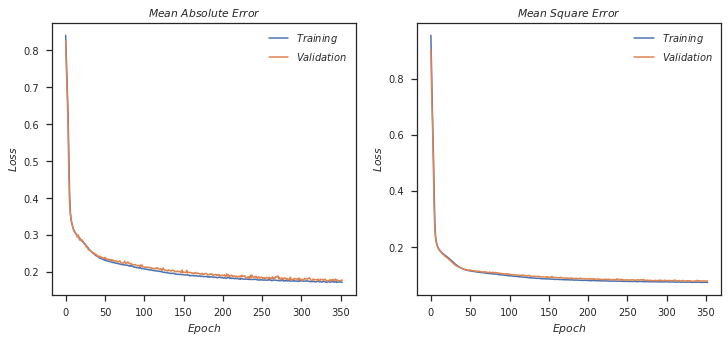

In [12]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [13]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

55/55 [==============================] - 0s 628us/step


In [14]:
n_c = 6

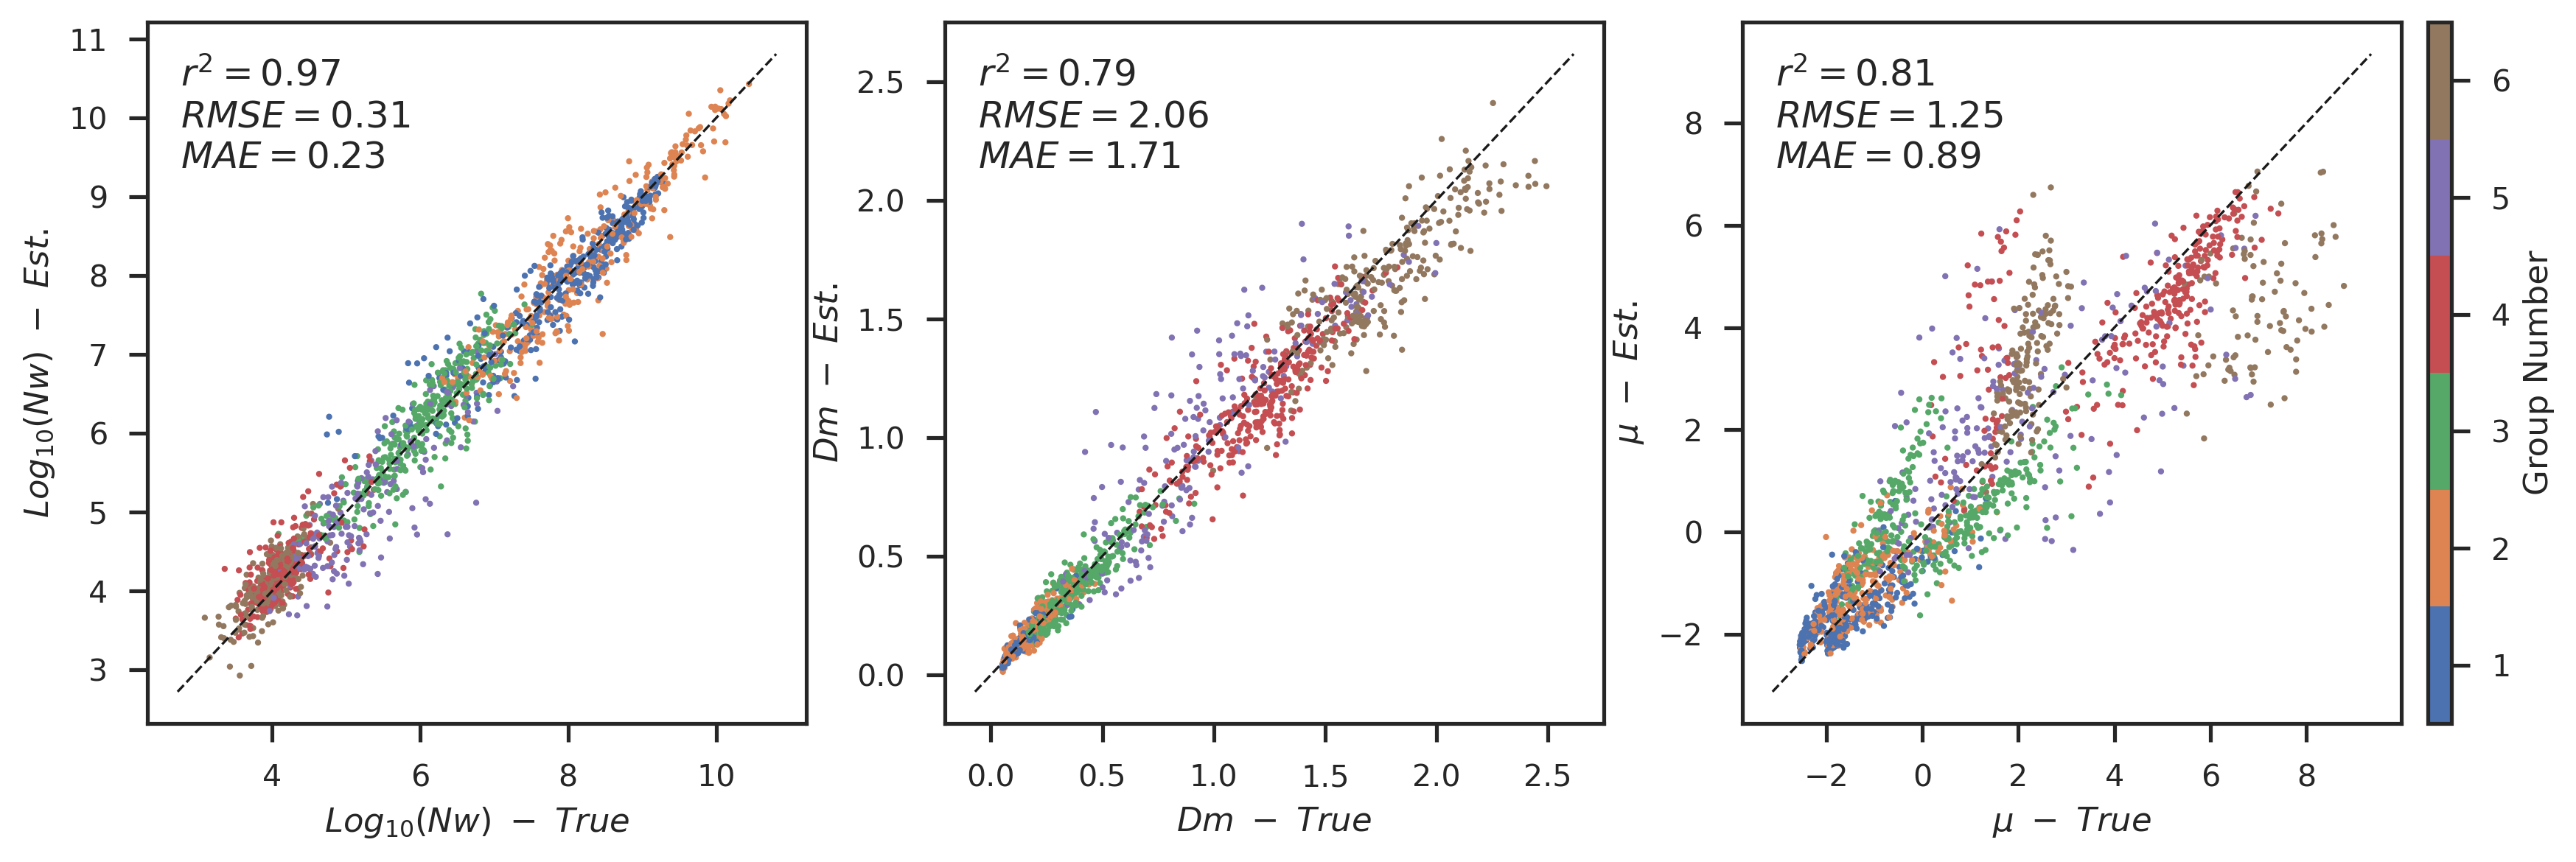

In [15]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
plt.savefig("../results/DNN_retrieval.svg", bbox_inches='tight')

In [16]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test.time.values),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

In [17]:
ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

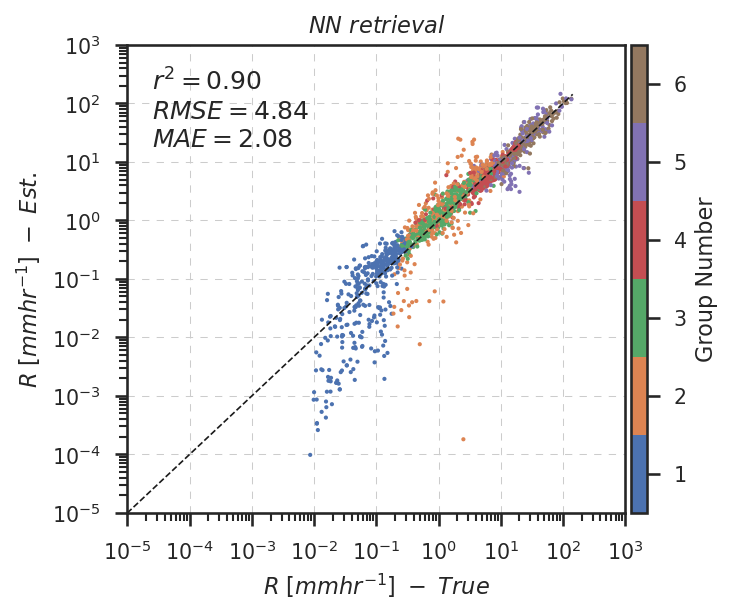

In [18]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
sc1 = ax.scatter(y_test.r, nn_rain.values, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test.r, nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()

ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-5, 1e3)
ax.set_xlim(1e-5, 1e3)
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))